In [1]:
# !export HF_HOME="/workspace/.cache/huggingface"
# !export HF_DATASETS_CACHE="/workspace/.cache/huggingface"

In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

/home/serikoo/miniconda3/envs/agreement-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
name = 'ai-forever/ruGPT-3.5-13B'
# name = 'ai-forever/mGPT-13B'
#name = 'ai-forever/rugpt3small_based_on_gpt2'
from utils import load_model_tokenizer_config
model, tokenizer, _ = load_model_tokenizer_config(name)

pytorch_model-00001-of-00006.bin: 100%|██████████| 9.92G/9.92G [09:44<00:00, 17.0MB/s]
pytorch_model-00002-of-00006.bin: 100%|██████████| 9.68G/9.68G [07:14<00:00, 22.3MB/s]
pytorch_model-00004-of-00006.bin: 100%|██████████| 10.0G/10.0G [11:28<00:00, 14.5MB/s]
Loading checkpoint shards:  33%|███▎      | 2/6 [00:22<00:44, 11.20s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 100.00 MiB (GPU 0; 19.70 GiB total capacity; 6.66 GiB already allocated; 100.56 MiB free; 6.81 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
import pandas as pd

df = pd.read_csv('stimuli.csv')

In [12]:
# df = df[['Prot', 'Sent', 'Group', 'N1', 'N2', 'Pred', 'Code', 'Sentence']]
df = df.dropna(axis=0)

In [13]:
import datasets
import numpy as np
import torch
from torch.nn import CrossEntropyLoss
from transformers import AutoModelForCausalLM, AutoTokenizer

import evaluate
from evaluate import logging

Split the text in two parts:

In [14]:
df['left'] = df['Sentence'].apply(lambda a: ' '.join(a.split(' ')[:3]))
df['right'] = df['Sentence'].apply(lambda a: ' '.join(a.split(' ')[3:]))

In [15]:
from tqdm.auto import tqdm

## Evaluation

In [16]:
def get_log_proba(text):
    all_tokens = tokenizer(f', {text},', return_tensors='pt').input_ids.to('cuda')
    prev_tokens = all_tokens[:, :-1]
    next_tokens = all_tokens[:, 1:]
    with torch.inference_mode():
        model_out = model(prev_tokens)
        tokens_log_proba = torch.gather(torch.log_softmax(model_out.logits, -1), 2, next_tokens.unsqueeze(-1))
        phrase_log_proba = tokens_log_proba.sum().item()
        
        #loss = model_out.loss
        #perplexity = torch.exp(loss)
        #phrase_log_proba = perplexity.item()
    return phrase_log_proba

In [17]:
df['p_w1'] = [get_log_proba(w) for w in tqdm(df.left)]
df['p_w2'] = [get_log_proba(w) for w in tqdm(df.right)]
df['p_phrase'] = [get_log_proba(w) for w in tqdm(df['Sentence'])]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

Считаем усредненную оценку, а именно p(весь текст) - p(левая часть текста) - p(правая часть текста)

In [18]:
df['compatibility_score'] = df['p_phrase'] - df['p_w2'] - df['p_w1']

In [20]:
df.head()

,Prot,Sent,Group,N1,N2,Pred,Code,Sentence,left,right,p_w1,p_w2,p_phrase,compatibility_score
0,1.0,1.0,1.0,S,S,S,S_S-S,Абонемент на концерт был дорогим из-за участия...,Абонемент на концерт,был дорогим из-за участия популярных артистов.,-28.359375,-56.28125,-74.0000,10.640625
1,2.0,1.0,1.0,S,S,P,P_S-S,Абонемент на концерт были дорогими из-за участ...,Абонемент на концерт,были дорогими из-за участия популярных артистов.,-28.359375,-55.06250,-79.3750,4.046875
2,3.0,1.0,1.0,S,P,S,S_S-P,Абонемент на концерты был дорогим из-за участи...,Абонемент на концерты,был дорогим из-за участия популярных артистов.,-27.984375,-56.28125,-74.5625,9.703125
3,4.0,1.0,1.0,S,P,P,P_S-P,Абонемент на концерты были дорогими из-за учас...,Абонемент на концерты,были дорогими из-за участия популярных артистов.,-27.984375,-55.06250,-75.9375,7.109375
4,5.0,1.0,1.0,P,S,S,S_P-S,Абонементы на концерт был дорогим из-за участи...,Абонементы на концерт,был дорогим из-за участия популярных артистов.,-28.640625,-56.28125,-75.6875,9.234375


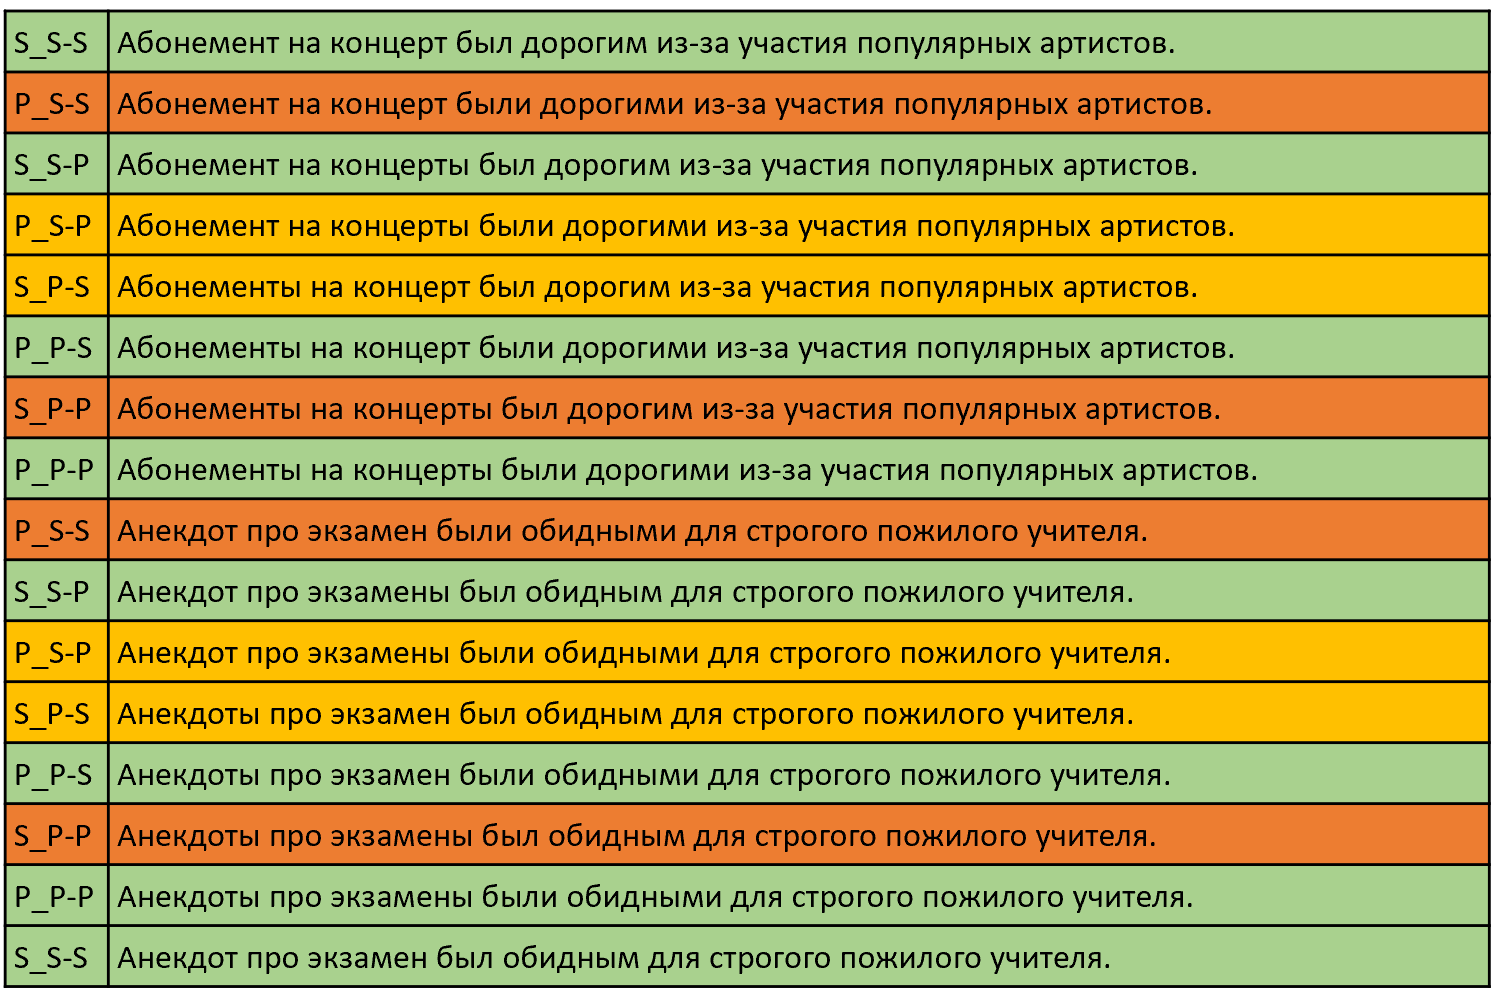

оценки между "пример с лоувшкой" и "явно неверный"

In [21]:
dff = df[df['Code'].isin(['S_P-S', 'S_P-P'])]\
    [['left', 'right', 'Sentence', 'Code','compatibility_score']].groupby(['right']).agg(list)

In [22]:
dff = df[df['Code'].isin(['S_S-S', 'P_S-S'])]\
                  [['left', 'Sentence', 'Code','compatibility_score']].groupby(['left']).agg(list)

In [23]:
dff['new_score'] = dff['compatibility_score'].agg(lambda a: max(a) / (min(a)+0.001) )

In [28]:
dff.sort_values('new_score', 
                ascending=True).head().style.background_gradient(cmap='rainbow')

,Sentence,Code,compatibility_score,new_score
left,,,,
Возражение на упрек,"['Возражение на упрек было принято без излишне бурных эмоций.', 'Возражение на упрек были приняты без излишне бурных эмоций.']","['S_S-S', 'P_S-S']","[3.078125, -0.078125]",-39.910859
Прыжок через костер,"['Прыжок через костер был рискованным для обладателей коротких ног.', 'Прыжок через костер были рискованными для обладателей коротких ног.']","['S_S-S', 'P_S-S']","[5.359375, -0.265625]",-20.252716
Ключ от шкатулки,"['Ключ от шкатулки был ржавым из-за высокой влажности воздуха.', 'Ключ от шкатулки были ржавыми из-за высокой влажности воздуха.']","['S_S-S', 'P_S-S']","[5.375, -0.34375]",-15.681984
Ссылка на сайт,"['Ссылка на сайт была дана в списке источников статьи.', 'Ссылка на сайт были даны в списке источников статьи.']","['S_S-S', 'P_S-S']","[7.484375, -0.765625]",-9.788295
Путешествие на курорт,"['Путешествие на курорт было приятным для членов большой семьи.', 'Путешествие на курорт были приятными для членов большой семьи.']","['S_S-S', 'P_S-S']","[6.984375, -2.453125]",-2.848295


## Проверка с помощью ANOVA

In [29]:
from scipy.stats import f_oneway

In [30]:
#все хорошие
f_oneway(df[df['Code'] == 'S_S-S']['compatibility_score'], 
         df[df['Code'] == 'S_S-P']['compatibility_score'],
         df[df['Code'] == 'P_P-P']['compatibility_score'], 
         df[df['Code'] == 'P_P-S']['compatibility_score'],
        )

F_onewayResult(statistic=0.8671594801026518, pvalue=0.4586715869255841)

In [31]:
#все плохие
f_oneway(df[df['Code'] == 'P_S-S']['compatibility_score'], 
         df[df['Code'] == 'S_P-P']['compatibility_score'],
        )

F_onewayResult(statistic=3.2092122998070836, pvalue=0.07562516085033398)

In [32]:
#все специальные
f_oneway(df[df['Code'] == 'P_S-P']['compatibility_score'], 
         df[df['Code'] == 'S_P-S']['compatibility_score'],
        )

F_onewayResult(statistic=0.9884457239749852, pvalue=0.32202801543611437)

In [33]:
# хорошие -- плохие
f_oneway(df[df['Code'].isin(['S_S-S','S_S-P','P_P-P','P_P-S'])]['compatibility_score'], 
         df[df['Code'].isin(['P_S-S','S_P-P']) ]['compatibility_score'],
        )

F_onewayResult(statistic=179.41211905729583, pvalue=8.265042853760483e-34)

In [34]:
# хорошие -- спец
f_oneway(df[df['Code'].isin(['S_S-S','S_S-P','P_P-P','P_P-S'])]['compatibility_score'], 
         df[df['Code'].isin(['P_S-P', 'S_P-S']) ]['compatibility_score'],
        )

F_onewayResult(statistic=118.46693023154116, pvalue=3.2609432297153905e-24)

In [35]:
# спец -- плохие
f_oneway(df[df['Code'].isin(['P_S-S','S_P-P'])]['compatibility_score'], 
         df[df['Code'].isin(['P_S-P', 'S_P-S']) ]['compatibility_score'],
        )

F_onewayResult(statistic=4.941619429278164, pvalue=0.027098024419834367)

In [36]:
df[['Code','compatibility_score']].groupby('Code')\
            .agg(['mean','std'])

compatibility_score          
                     mean       std
Code                               
P_P-P            8.355225  3.462925
P_P-S            9.080078  3.737577
P_S-P            5.118652  3.558621
P_S-S            4.395264  3.516317
S_P-P            3.299072  3.405765
S_P-S            4.509277  3.373373
S_S-P            9.091797  3.542276
S_S-S            9.295166  3.414400

In [32]:
df.to_csv(r'./stimuli_2018_test2_alt_withpred.csv', encoding='utf8')

## Простая перплексия

In [37]:
predictions = df['Sentence'].to_list()

In [38]:
tokenizer.pad_token = tokenizer.eos_token

In [39]:
encodings = tokenizer(
    predictions,
    add_special_tokens=False,
    padding=True,
    truncation=True,
    max_length=32,
    return_tensors="pt",
    return_attention_mask=True,
    ).to('cuda')

encoded_texts = encodings["input_ids"]
attn_masks = encodings["attention_mask"]

batch_size = 12

ppls = []
loss_fct = CrossEntropyLoss(reduction="none")

for start_index in logging.tqdm(range(0, len(encoded_texts), batch_size)):
    end_index = min(start_index + batch_size, len(encoded_texts))
    encoded_batch = encoded_texts[start_index:end_index]
    attn_mask = attn_masks[start_index:end_index]

    if False:
        bos_tokens_tensor = torch.tensor([[tokenizer.bos_token_id]] * encoded_batch.size(dim=0)).to(device)
        encoded_batch = torch.cat([bos_tokens_tensor, encoded_batch], dim=1)
        attn_mask = torch.cat(
            [torch.ones(bos_tokens_tensor.size(), dtype=torch.int64).to(device), attn_mask], dim=1
        )

    labels = encoded_batch

    with torch.no_grad():
        out_logits = model(encoded_batch, attention_mask=attn_mask).logits

    shift_logits = out_logits[..., :-1, :].contiguous()
    shift_labels = labels[..., 1:].contiguous()
    shift_attention_mask_batch = attn_mask[..., 1:].contiguous()

    perplexity_batch = torch.exp(
        (loss_fct(shift_logits.transpose(1, 2), shift_labels) * shift_attention_mask_batch).sum(1)
        / shift_attention_mask_batch.sum(1)
    )

    ppls += perplexity_batch.tolist()

  0%|          | 0/43 [00:00<?, ?it/s]

In [40]:
df['GPT3'] = ppls

In [41]:
df.head()

,Prot,Sent,Group,N1,N2,Pred,Code,Sentence,left,right,p_w1,p_w2,p_phrase,compatibility_score,GPT3
0,1.0,1.0,1.0,S,S,S,S_S-S,Абонемент на концерт был дорогим из-за участия...,Абонемент на концерт,был дорогим из-за участия популярных артистов.,-28.359375,-56.28125,-74.0000,10.640625,2560.0
1,2.0,1.0,1.0,S,S,P,P_S-S,Абонемент на концерт были дорогими из-за участ...,Абонемент на концерт,были дорогими из-за участия популярных артистов.,-28.359375,-55.06250,-79.3750,4.046875,793.0
2,3.0,1.0,1.0,S,P,S,S_S-P,Абонемент на концерты был дорогим из-за участи...,Абонемент на концерты,был дорогим из-за участия популярных артистов.,-27.984375,-56.28125,-74.5625,9.703125,2746.0
3,4.0,1.0,1.0,S,P,P,P_S-P,Абонемент на концерты были дорогими из-за учас...,Абонемент на концерты,были дорогими из-за участия популярных артистов.,-27.984375,-55.06250,-75.9375,7.109375,871.0
4,5.0,1.0,1.0,P,S,S,S_P-S,Абонементы на концерт был дорогим из-за участи...,Абонементы на концерт,был дорогим из-за участия популярных артистов.,-28.640625,-56.28125,-75.6875,9.234375,1808.0


In [42]:
df.to_csv(r'./stimuli_2018_test1_withpred.csv', encoding='utf8')

## Квази-перплексия (лучше не использовать)

In [42]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("microsoft/mdeberta-v3-base")
model = AutoModelForMaskedLM.from_pretrained("microsoft/mdeberta-v3-base")

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Some weights of DebertaV2ForMaskedLM were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [99]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("s-nlp/ruRoberta-large-RuCoLa-v1")
model = AutoModelForSequenceClassification.from_pretrained("s-nlp/ruRoberta-large-RuCoLa-v1")

from transformers import TextClassificationPipeline

class Quazi(TextClassificationPipeline):
    def postprocess(self, model_outputs):
        best_class = model_outputs["logits"]
        return best_class

pipe = Quazi(model=model, tokenizer=tokenizer)

In [102]:
raw = pipe(df['Sentence'].to_list(), batch_size=32)

In [119]:
a = []
b = []
for i in raw:
    ar = i.tolist()[0]
    a.append(ar[0])
    b.append(ar[1])

In [121]:
df['rucola0'] = a
df['rucola1'] = b

In [125]:
#df.to_csv(r'./stimuli_2018_test1_withpred.csv', encoding='utf8')

In [43]:
def calculate_perplexity(sentence):
    inputs = tokenizer(sentence, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs['input_ids'])
    loss = outputs.loss
    perplexity = torch.exp(loss)
    return perplexity.item()

In [44]:
df['mdeberta-v3-base'] = df['Sentence'].apply(lambda a: calculate_perplexity(a))

## подвал

In [ ]:
perplexity = evaluate.load("perplexity", module_type="metric")
input_texts = ["lorem ipsum", "Happy Birthday!", "Bienvenue"]

results = perplexity.compute(model_id='gpt2',
                             add_start_token=False,
                             predictions=input_texts)
print(list(results.keys()))

In [44]:
encodings = tokenizer("Абонемент на концерт были дорогими из-за участия популярных артистов.", return_tensors="pt")

In [48]:
encodings

{'input_ids': tensor([[28130,   361, 43577,   310, 11035,  1027,  5990,   356,   419,    18,
           440,  9379, 15896, 35586,    19]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [49]:
tokenizer("Абонемент на концерт был дорогими из-за участия популярных артистов.", return_tensors="pt")

{'input_ids': tensor([[28130,   361, 43577,   310, 11035,   776,  5990,   356,   419,    18,
           440,  9379, 15896, 35586,    19]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [45]:
device='cuda'

In [50]:
import torch
from tqdm import tqdm

max_length = model.config.n_positions
stride = 1
seq_len = encodings.input_ids.size(1)

nlls = []
prev_end_loc = 0
for begin_loc in tqdm(range(0, seq_len, stride)):
    end_loc = min(begin_loc + max_length, seq_len)
    trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
    print(begin_loc, end_loc, trg_len)
    input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
    target_ids = input_ids.clone()
    target_ids[:, :-trg_len] = -100

    with torch.no_grad():
        outputs = model(input_ids, labels=target_ids)

        # loss is calculated using CrossEntropyLoss which averages over valid labels
        # N.B. the model only calculates loss over trg_len - 1 labels, because it internally shifts the labels
        # to the left by 1.
        neg_log_likelihood = outputs.loss

    nlls.append(neg_log_likelihood)

    prev_end_loc = end_loc
    if end_loc == seq_len:
        break

ppl = torch.exp(torch.stack(nlls).mean())

  0%|                                                                                            | 0/15 [00:00<?, ?it/s]

0 15 15


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]


In [43]:
ppl

tensor(55.6875, device='cuda:0', dtype=torch.float16)

In [47]:
ppl

tensor(62.5938, device='cuda:0', dtype=torch.float16)

In [3]:
name = "nolanoAI/lordcoder-v0-13-2B"

In [ ]:
from accelerate import init_empty_weights
with init_empty_weights():
    my_model = AutoModelForCausalLM.from_pretrained(name,trust_remote_code=True,)
    print(my_model)

In [9]:
prompt = '# PyTorch CNN on MNIST\nimport torch\n'

# Run text-generation pipeline
pipe = pipeline('text-generation', model=model, tokenizer=tokenizer)

# Generate output
output = pipe(
    prompt,
    max_new_tokens=256,
    top_k=40,
    top_p=0.85,
    repetition_penalty=1.1,
    do_sample=True,
    use_cache=False,
)
print(output[0]['generated_text'])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


# PyTorch CNN on MNIST
import torch
from gensim.models import Sequential, Comparable
from gensim.mixins import ModelMixin
from torchtesting.cnnclassifier import CNNClassifier
from torchtesting.libtorchfile import LibtorchTestClassFile
import scikit-learn
from sklearn.neighbors import TournamentRankGenerator as NG_TRank

def cnnparser(s):
    """Convert a PyTorch python script into a valid C++ code."""
    cnn = Scanner(s).read()
    return ['CONSTRAINED_COMPARABILITY',
            'COMPATIBLE_RANKS',
            'ORDERING',
            'LIMITATION_VALUE',
            'RESULTS']

def test_random_word(self):
    seq_train = self.open('seq_training.scss', 'wb')


In [ ]:
inputs = {k: v.to(device) for k,v in tokenizer('# PyTorch CNN on MNIST\nimport torch\n', return_tensors='pt').items()}

generated_ids = model.generate(
        **inputs,
        use_cache=True,
        max_new_tokens=500,
        temperature=0.1,
        top_p=0.95,
        do_sample=True,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
    )

In [ ]:
# Sample texts
system_prompt = (
    "Ты - модель искусственного интеллекта ruGPT-3.5 13B, которая очень хорошо следует инструкциям. "
    "Твоя задача - помогать пользователю и отвечать на вопросы. "
    "Будь внимательна и не делай ничего противозаконного."
)
bot_message = 'Привет, чем я могу помочь?'
message = "Напиши стихотворение о программистах"
prompt = f"### Система:\n{system_prompt}\n\n### Бот:\n{bot_message}\n\n### Пользователь:\n{message}\n\n### Бот:\n"

# Run text-generation pipeline
pipe = pipeline('text-generation', model=model, tokenizer=tokenizer)

# Generate output
output = pipe(
    prompt,
    max_new_tokens=256,
    top_k=40,
    top_p=0.85,
    repetition_penalty=1.1,
    do_sample=True,
    use_cache=False,
)
print(output[0]['generated_text'])

In [14]:
def get_log_proba(text):
    all_tokens = tokenizer(f', {text},', return_tensors='pt').input_ids.to('cuda')
    prev_tokens = all_tokens[:, :-1]
    next_tokens = all_tokens[:, 1:]
    with torch.inference_mode():
        model_out = model(prev_tokens)
        tokens_log_proba = torch.gather(torch.log_softmax(model_out.logits, -1), 2, next_tokens.unsqueeze(-1))
        phrase_log_proba = tokens_log_proba.sum().item()
        
        #loss = model_out.loss
        #perplexity = torch.exp(loss)
        #phrase_log_proba = perplexity.item()
    return phrase_log_proba

print(get_log_proba('обзор журналов'))

-21.28125


In [ ]:
a = ["Абонемент на концерт",
"Абонемент на концерт", 
"Абонемент на концерты", 
"Абонемент на концерты", 
"Абонементы на концерт",
"Абонементы на концерт",
"Абонементы на концерты",
"Абонементы на концерты",]

b = ["был дорогим из-за участия популярных артистов.",
 "были дорогими из-за участия популярных артистов.",
 "был дорогим из-за участия популярных артистов.",
 "были дорогими из-за участия популярных артистов.",
 "был дорогим из-за участия популярных артистов.",
 "были дорогими из-за участия популярных артистов.",
 "был дорогим из-за участия популярных артистов.",
 "были дорогими из-за участия популярных артистов."]

In [17]:
import pandas as pd

In [18]:
new = pd.DataFrame()
new['w1'] = a
new['w2'] = b
new['phrase'] = new['w1'] +' '+ new['w2']

In [19]:
new['p_w1'] = [get_log_proba(w) for w in new.w1]
new['p_w2'] = [get_log_proba(w) for w in new.w2]
new['p_phrase'] = [get_log_proba(w) for w in new.phrase]

In [20]:
new['compatibility_score'] = new['p_phrase'] - new['p_w2'] - new['p_w1']
new.style.background_gradient(cmap='rainbow')

,w1,w2,phrase,p_w1,p_w2,p_phrase,compatibility_score
0,Абонемент на концерт,был дорогим из-за участия популярных артистов.,Абонемент на концерт был дорогим из-за участия популярных артистов.,-28.359375,-56.281250,-74.000000,10.640625
1,Абонемент на концерт,были дорогими из-за участия популярных артистов.,Абонемент на концерт были дорогими из-за участия популярных артистов.,-28.359375,-55.062500,-79.375000,4.046875
2,Абонемент на концерты,был дорогим из-за участия популярных артистов.,Абонемент на концерты был дорогим из-за участия популярных артистов.,-27.984375,-56.281250,-74.562500,9.703125
3,Абонемент на концерты,были дорогими из-за участия популярных артистов.,Абонемент на концерты были дорогими из-за участия популярных артистов.,-27.984375,-55.062500,-75.937500,7.109375
4,Абонементы на концерт,был дорогим из-за участия популярных артистов.,Абонементы на концерт был дорогим из-за участия популярных артистов.,-28.640625,-56.281250,-75.687500,9.234375
5,Абонементы на концерт,были дорогими из-за участия популярных артистов.,Абонементы на концерт были дорогими из-за участия популярных артистов.,-28.640625,-55.062500,-73.125000,10.578125
6,Абонементы на концерты,был дорогим из-за участия популярных артистов.,Абонементы на концерты был дорогим из-за участия популярных артистов.,-26.453125,-56.281250,-78.312500,4.421875
7,Абонементы на концерты,были дорогими из-за участия популярных артистов.,Абонементы на концерты были дорогими из-за участия популярных артистов.,-26.453125,-55.062500,-71.375000,10.140625


In [25]:
torch.exp(torch.tensor([-28.359375]))

tensor([4.8270e-13])

In [ ]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig

MODEL_NAME = "IlyaGusev/saiga_mistral_7b"

config = PeftConfig.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    config.base_model_name_or_path,
    torch_dtype=torch.float16,
    device_map="auto"
)
model = PeftModel.from_pretrained(
    model,
    MODEL_NAME,
    torch_dtype=torch.float16
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)